# Capacity Building
## Prerequisites
Some basic understanding of Python variables, data types, looping, conditionals and functions will be of benefit.
## Data inputs
### Import modules/packages

Let's import some modules/packages. A module or package is pre-built Python code that we can leverage to provide useful functionality.<br> Generally, it will have the form of *module_name.function*

In [1]:
%pip install summerepi

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd  # pd is an alias for pandas. This is similar to dataframes in R
import matplotlib.pyplot as plt  # matplotlib is a common visualisation package for Python
from datetime import datetime, timedelta  # We use datetime to manipulate date-time indexes

plt.style.use('ggplot')  # This sets the style of the plots

Try: There's a function inside plt.style that will show the styles. Change the plotting style to something you like.

### Define constants
Defining and capitalising constants at the start of a Python script is common practice.

In [3]:
# URL to the Ministry of health's GitHub repository.
# What is the data type here, a tuple or string? Do you know how to check for the type?
GITHUB_MOH = (
    "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/"
)

# A list containing the files to download.
FILES = [
    "cases_malaysia",
    "deaths_malaysia",
    "hospital",
    "icu",
    "cases_state",
    "deaths_state",
]

# By defining a region parameter, we can easily change the analysis later.
REGION = "Malaysia"

# We define a day zero for the analysis.
COVID_BASE_DATE = datetime(2019, 12, 31)


### Utility functions

In [4]:
def fetch_mys_data(a_url:str)->pd.DataFrame:
    """Request files from MoH and combine them into one data frame.
    Args:
        a_url (str): A url to fetch data from.

    Returns:
        pd.DataFrame: A data frame containing all the files.
    """
    a_list = []  # An empty list to hold each dataframe (a list can hold any python object)
    for file in FILES:  # Loop over each file name
        data_type = file.split('_')[0]  # Split the file name on '_' and take the first part.
        df = pd.read_csv(a_url + file + ".csv")  # Build the full url path to the file and ask pandas to download it. 
        df['type']  = data_type  # Create a new column 'type' and enter the data_type.

        a_list.append(df)  # Place this dataframe into the list. 

    # We have looped over all the files, downloaded and entered it into a list of shape [df1,df2,df3,...].
    
    # Pandas will automatically combine this list into a single dataframe. It will expand the rows and columns as necessary.
    df = pd.concat(a_list) 
    
    return df # The function returns the dataframe.

Now call the function and pass it the MoH url.<br> Well done! We have scraped Malaysia's entire national and regional Covid-19 dataset into one dataframe

In [5]:
df = fetch_mys_data(GITHUB_MOH)
df

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,vent,vent_port,icu_covid,icu_pui,icu_noncovid,vent_covid,vent_pui,vent_noncovid,vent_used,vent_port_used
0,2020-01-25,4.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3.0,3.0,0.0,7.0,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13019,2022-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13020,2022-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13021,2022-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13022,2022-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['date', 'cases_new', 'cases_import', 'cases_recovered', 'cases_active',
       'cases_cluster', 'cases_unvax', 'cases_pvax', 'cases_fvax',
       'cases_boost', 'cases_child', 'cases_adolescent', 'cases_adult',
       'cases_elderly', 'cases_0_4', 'cases_5_11', 'cases_12_17',
       'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
       'cases_60_69', 'cases_70_79', 'cases_80', 'cluster_import',
       'cluster_religious', 'cluster_community', 'cluster_highRisk',
       'cluster_education', 'cluster_detentionCentre', 'cluster_workplace',
       'type', 'deaths_new', 'deaths_bid', 'deaths_new_dod', 'deaths_bid_dod',
       'deaths_unvax', 'deaths_pvax', 'deaths_fvax', 'deaths_boost',
       'deaths_tat', 'state', 'beds', 'beds_covid', 'beds_noncrit',
       'admitted_pui', 'admitted_covid', 'admitted_total', 'discharged_pui',
       'discharged_covid', 'discharged_total', 'hosp_covid', 'hosp_pui',
       'hosp_noncovid', 'beds_icu', 'beds_icu_rep', 'beds_icu_total',
 

In [7]:
df['state']

0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
               ...        
13019             Selangor
13020           Terengganu
13021    W.P. Kuala Lumpur
13022          W.P. Labuan
13023       W.P. Putrajaya
Name: state, Length: 53578, dtype: object

We need to do some housekeeping.
- Fill the missing state values with 'Malaysia'
- Ensure the date type is correct and not a string '10-06-2022'
- Create an integer offset from COVID_BASE_DATE. 

In [8]:
df.loc[df['state'].isna(), 'state'] = 'Malaysia' 
df['date'] = pd.to_datetime(df['date'])
df['date_index'] = (df['date'] - COVID_BASE_DATE).dt.days

Let's create a boolean mask to aid with our analysis. Recall the 'REGION' variable we set at the beginning and the type column we created while downloading the data.<br>

We define a "filter". In this example, it's for Malaysia's cases. By changing the 'REGION' variable and or type column, we can change the focus of the analysis.

In [9]:
filter = (df['state'] == REGION) & (df['type'] == 'cases')

In [10]:
df[filter][['date', 'cases_new','deaths_new']]  # Notice how the death data is NaN due to the filtering

,date,cases_new,deaths_new
0,2020-01-25,4.0,NaN
1,2020-01-26,0.0,NaN
2,2020-01-27,0.0,NaN
3,2020-01-28,0.0,NaN
4,2020-01-29,3.0,NaN
...,...,...,...
861,2022-06-04,1591.0,NaN
862,2022-06-05,1358.0,NaN
863,2022-06-06,1330.0,NaN
864,2022-06-07,1128.0,NaN


After all that work, let's look at the results.<br />
Pandas has a .plot() function. Here is a [quick](https://pandas.pydata.org/docs/getting_started/intro_tutorials/04_plotting.html) or [detailed](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html?highlight=plot) tutorial.<br />
We can also use `x='date_index` and change the `y` to any `case_` column.

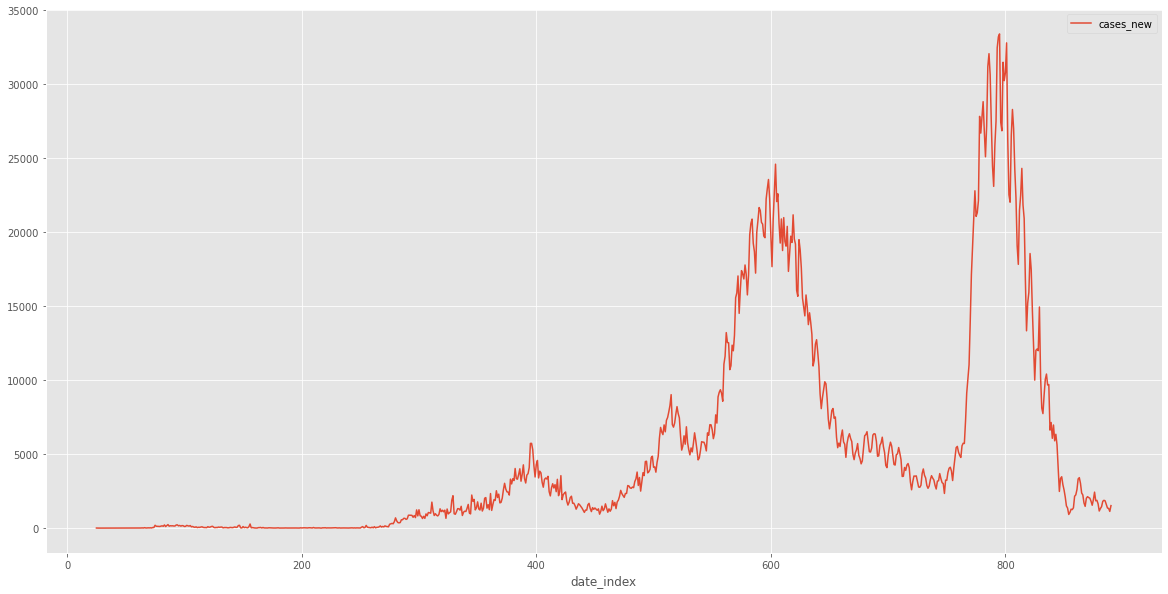

In [11]:
df[filter].plot(x='date_index', y='cases_new', figsize=(20, 10));

Let's also download the latest population distributions from the MoH GitHub repository.

In [12]:
POPULATION = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/static/population.csv'
df_pop = pd.read_csv(POPULATION)

In [13]:
df_pop

,state,idxs,pop,pop_18,pop_60,pop_12,pop_5
0,Malaysia,0,32657100,23528200,3649000,3111400,3550500
1,Johor,1,3794200,2733400,445600,353900,409800
2,Kedah,2,2193600,1554800,282300,209700,254100
3,Kelantan,3,1928900,1258700,202100,211200,271700
4,Melaka,4,937800,683700,123200,85600,98200
5,Negeri Sembilan,5,1128900,819200,150300,105900,117200
6,Pahang,6,1684700,1188000,198100,172000,192600
7,Pulau Pinang,7,1774200,1374300,247600,139400,155600
8,Perak,8,2509000,1878100,410000,228000,239700
9,Perlis,9,255500,182100,36300,23000,29100


In [14]:
initial_population = df_pop[df_pop['state'] == REGION]['pop'][0]

## Basic model introduction

This page introduces the processes for building and running a simple compartmental disease model with Summer.
In the following example, we will create an SIR compartmental model for a general, unspecified emerging infectious disease spreading through a fully susceptible population. In this model there will be:

- three compartments: susceptible (S), exposed(E), infected (I) and recovered (R)
- a starting population of the REGION, with 100 of them infected (and infectious)
- an evaluation timespan from day zero to END_DATE in 0.1 day steps
- inter-compartmental flows for infection, deaths and recovery

First, let's look at a complete example of this model in action, and then examine the details of each step. This is the complete example model that we will be working with:

In [15]:
import numpy as np
from summer import CompartmentalModel

start_date = datetime(2021,1,1) # Define the start date.
end_date = start_date + timedelta(days=300) # Define the duration.

# Integer representation of the start and end dates.
start_date_int = (start_date - COVID_BASE_DATE).days
end_date_int = (end_date- COVID_BASE_DATE).days

In [16]:
# Define the model compartments and time step.
model = CompartmentalModel(
    times=(start_date_int, end_date_int),
    compartments=["S", "E", "I", "R"],
    infectious_compartments=["I"],
    timestep=0.1,
)

In [17]:
# Define the initial population and compartmental flows.
model.set_initial_population(distribution={"S": 100000, "E": 0, "I": 100})
model.add_infection_frequency_flow(name="exposure", contact_rate=0.12, source="S", dest="E")
model.add_transition_flow(name="infection", fractional_rate=1/15, source="E", dest="I")
model.add_transition_flow(name="recovery", fractional_rate=0.04, source="I", dest="R")
#model.add_death_flow(name="infection_death", death_rate=0.05, source="I")

# Run the model
model.run()


Our `model` object has many `model.functions()` attached to it. You are encouraged to explore these functions as this object is integral to the platform.

In [18]:
output_df = model.get_outputs_df()

We now have a Pandas dataframe of compartments sizes at each time step.

In [19]:
output_df.head(20)

,S,E,I,R
367.0,100000.000000,0.000000,100.000000,0.000000
367.1,99998.803584,1.192434,99.604775,0.399206
367.2,99997.611864,2.372265,99.219020,0.796851
367.3,99996.424726,3.539690,98.842613,1.192971
367.4,99995.242058,4.694902,98.475435,1.587604
367.5,99994.063752,5.838092,98.117369,1.980787
367.6,99992.889698,6.969448,97.768299,2.372555
367.7,99991.719788,8.089156,97.428111,2.762945
367.8,99990.553918,9.197398,97.096693,3.151992
367.9,99989.391981,10.294356,96.773933,3.539730


Extract the target data from the MoH dataframe.

In [20]:
target = df[filter][start_date_int: end_date_int]['cases_new']
xrange = range(start_date_int, end_date_int) # Create a integer range from the start date to the end date.

Useful Matplotlib [guide](https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py)

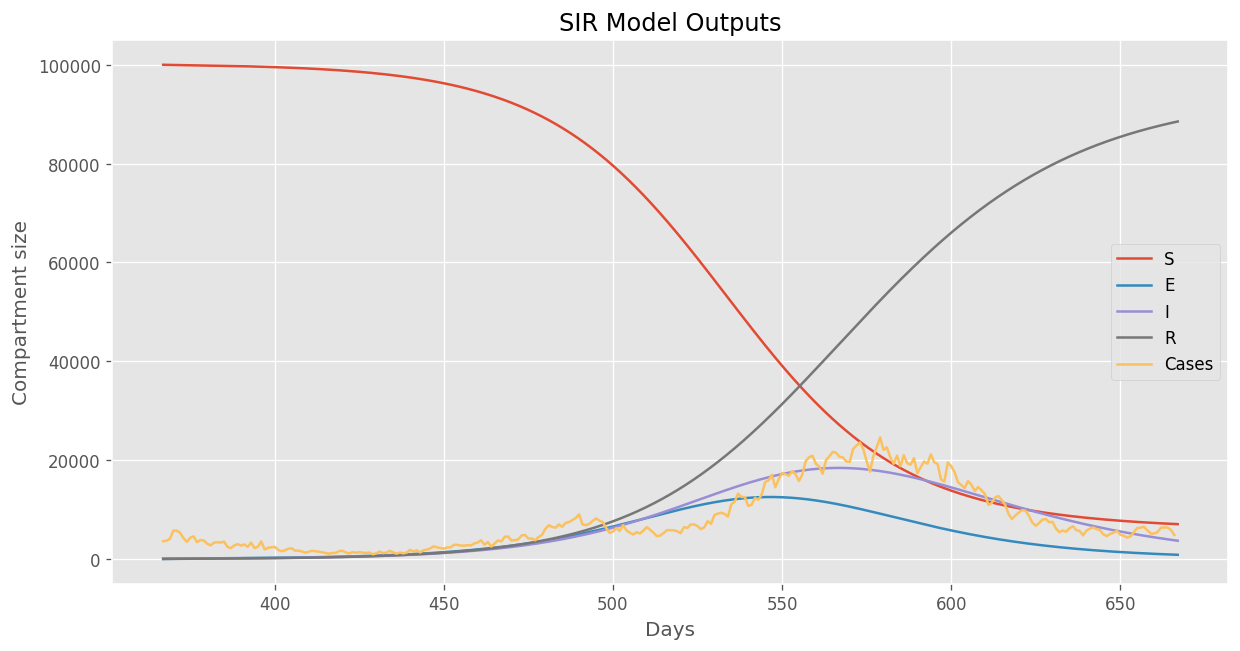

In [21]:
# Visualize the results.
subplot = {"title": "SIR Model Outputs", "xlabel": "Days", "ylabel": "Compartment size"} # A dictionary of key:values pairs that matplotlib will use to label items.
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120, subplot_kw=subplot) # Create a subplot object.

for compartment in output_df: # Loop over each compartment. 
    ax.plot(model.times, output_df[compartment]) # Plot the times and compartment values

ax.plot(xrange, target) # Also plot the MoH target values.

ax.legend(["S", "E","I", "R","Cases"])
plt.show();


Now let's inspect each step of the example in more detail. To start, here's how to create a new model: let's import the summer library and create a new [CompartmentalModel](/api/model.html) object. You can see that our model has an attribute called `compartments`, which contains a description of each modelled compartment.

In [22]:
# Define the model
model = CompartmentalModel(
    times=(start_date_int, end_date_int),
    compartments=["S", "E", "I", "R"],
    infectious_compartments=["I"],
    timestep=0.1,
)

### Adding a population 

Initially the model compartments are all empty. Let's add:

- 100000 people to the susceptible (S) compartment, plus
- 100 in the infectious (I) compartment.

In [23]:
# Add people to the model
model.set_initial_population(distribution={"S": 100000, "E": 0, "I": 100})

# View the initial population
model.initial_population

array([100000.,      0.,    100.,      0.])

### Adding inter-compartmental flows 

Now, let's add some flows for people to transition between the compartments. These flows will define the dynamics of our infection. We will add:

- an infection flow from S to E (using frequency-dependent transmission)
- an exposed individual becomes infected E to I.
- a recovery flow from I to R

In [32]:
# Susceptible people can get infected.
model.add_infection_frequency_flow(name="infection", contact_rate=0.12, source="S", dest="E")

# Expose people transition to infected.
model.add_transition_flow(name="progression", fractional_rate=1/15, source="E", dest="I")

# Infectious people recover.
model.add_transition_flow(name="recovery", fractional_rate=0.04, source="I", dest="R")

# Inspect the new flows, which we just added to the model.
model._flows

model.request_output_for_flow("notifications", "progression")

### Running the model

Now we can calculate the outputs for the model over the requested time period. 
The model calculates the compartment sizes by solving a system of differential equations (defined by the flows we just added) over the requested time period.

In [33]:
model.run()

### Print the model outputs

The model's results are available in a NumPy array named `model.outputs`. 
This array is available after the model has been run. Let's have a look at what's inside:

In [34]:
# Force NumPy to format the output array nicely. 
import numpy as np
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

# View the first 25 timesteps of the output array.
model.outputs[:25]

array([[100000.00, 0.00, 100.00, 0.00],
       [99996.42, 3.54, 98.84, 1.19],
       [99992.89, 6.97, 97.77, 2.37],
       [99989.39, 10.29, 96.77, 3.54],
       [99985.93, 13.52, 95.86, 4.70],
       [99982.50, 16.65, 95.01, 5.84],
       [99979.09, 19.69, 94.24, 6.98],
       [99975.72, 22.64, 93.54, 8.10],
       [99972.37, 25.51, 92.90, 9.22],
       [99969.04, 28.30, 92.33, 10.33],
       [99965.73, 31.02, 91.82, 11.44],
       [99962.44, 33.66, 91.36, 12.54],
       [99959.16, 36.24, 90.97, 13.63],
       [99955.89, 38.76, 90.63, 14.72],
       [99952.64, 41.21, 90.34, 15.81],
       [99949.40, 43.60, 90.11, 16.89],
       [99946.16, 45.94, 89.93, 17.97],
       [99942.93, 48.23, 89.79, 19.05],
       [99939.71, 50.47, 89.70, 20.12],
       [99936.48, 52.66, 89.65, 21.20],
       [99933.26, 54.81, 89.65, 22.28],
       [99930.04, 56.91, 89.69, 23.35],
       [99926.82, 58.98, 89.78, 24.43],
       [99923.59, 61.01, 89.90, 25.51],
       [99920.35, 63.00, 90.06, 26.59]])

In [38]:
model.derived_outputs["notifications"][:25]

array([0.00, 0.02, 0.07, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36, 0.40,
       0.43, 0.47, 0.50, 0.53, 0.57, 0.60, 0.63, 0.66, 0.69, 0.72, 0.74,
       0.77, 0.80, 0.83])

### Plot the outputs

You can get a better idea of what is going on inside the model by visualising how the compartment sizes change over time.

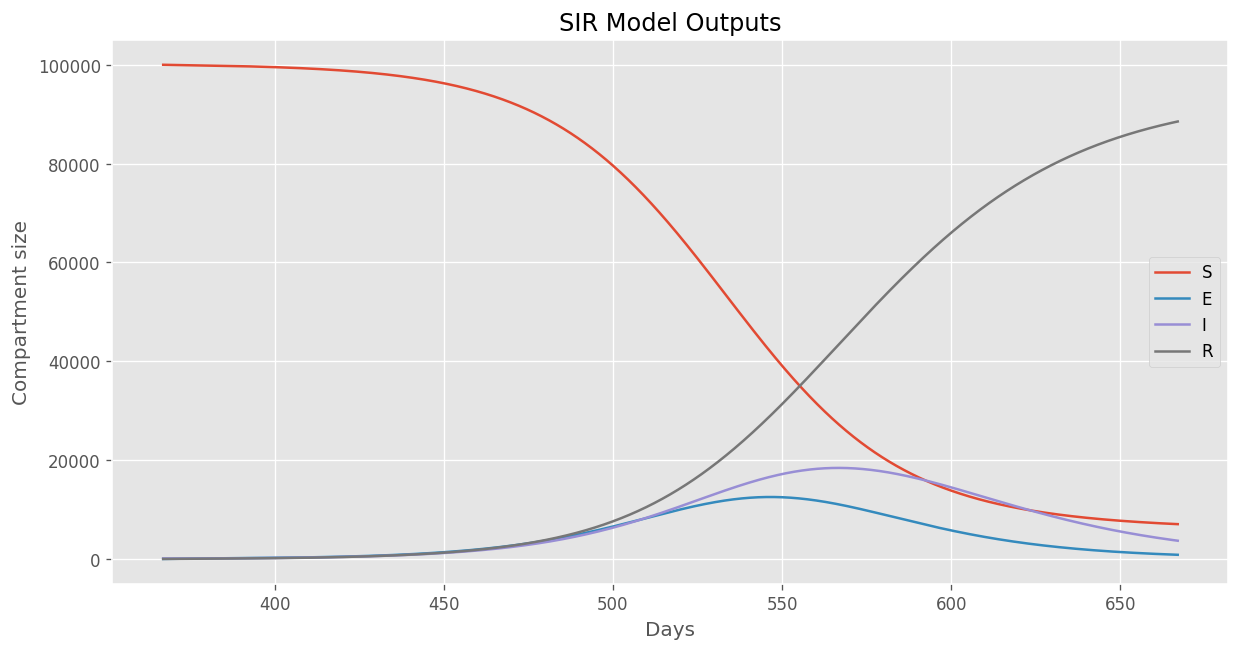

In [42]:
# Visualize the results.
subplot = {"title": "SIR Model Outputs", "xlabel": "Days", "ylabel": "Compartment size"}
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120, subplot_kw=subplot)

for compartment in output_df: # Loop over each compartment. 
    ax.plot(model.times, output_df[compartment]) # Plot the times and compartment values

ax.legend(["S", "E", "I", "R"])
plt.show();

{'notifications': array([0.00, 0.02, 0.07, ..., 0.00, 0.00, 0.00])}

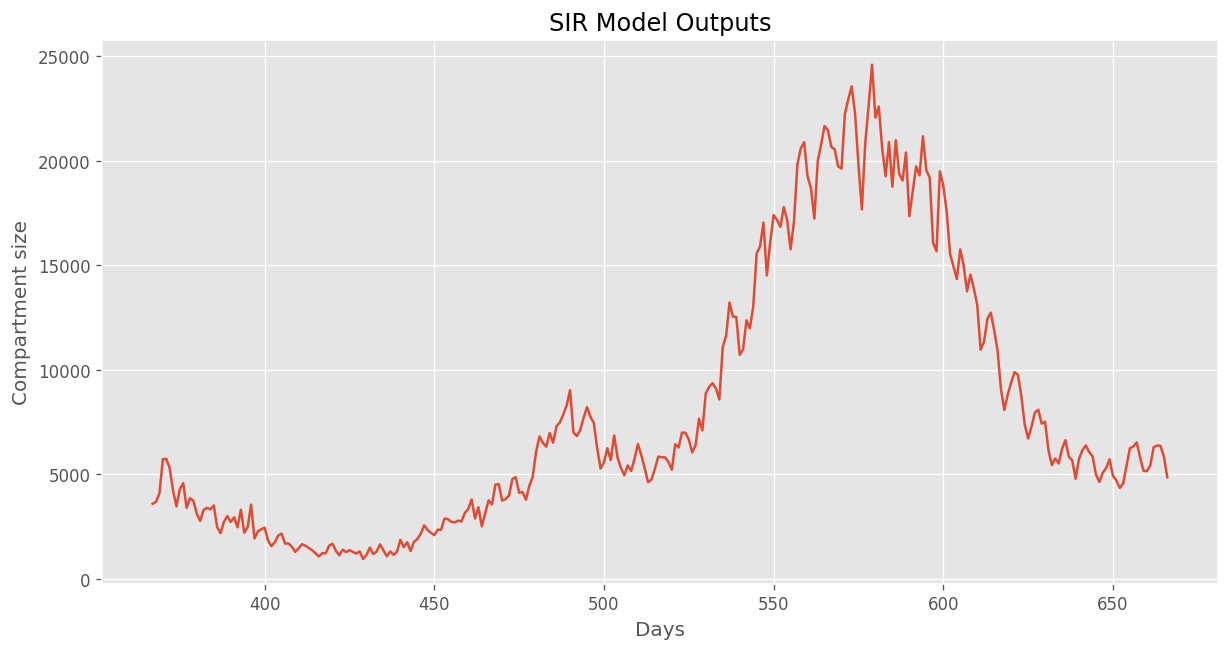

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120, subplot_kw=subplot)
ax.plot(xrange, target)  # Plot the MoH target values.
model.derived_outputs

## Summary

That's it for now, now you know how to:

- Create a model
- Add a population
- Add flows
- Run the model
- Access and visualise the outputs

A detailed API reference for the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)